In [2]:
from pandas import ExcelWriter

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as et

# %load_ext nb_black

In [3]:
path = r"D:\tencent_files\chrome_Download\Research\Equilibium_modelling\H2MetalDemand\Data Collection\Scenario_data"
Tech_database = "H2Tec_database.xlsx"
ssp = [1, 2, 4, 5]
RCP = [2.6, 1.9]
scenario_name_list = [
    "ssp" + str(ssp_n) + "_RCP" + str(RCP_n) + ".xlsx" for ssp_n in ssp for RCP_n in RCP
]
scenario_name_ex = ["ssp1_RCP2.6_hy1.xlsx", "ssp1_RCP1.9_hy1.xlsx","ssp4_RCP2.6_hy1.xlsx"]
scenario_name_list = scenario_name_list + scenario_name_ex
sheet_name = ["H2_prod", "H2_con", "H2_ind", "H2_trn"]
scenario_name_list

['ssp1_RCP2.6.xlsx',
 'ssp1_RCP1.9.xlsx',
 'ssp2_RCP2.6.xlsx',
 'ssp2_RCP1.9.xlsx',
 'ssp4_RCP2.6.xlsx',
 'ssp4_RCP1.9.xlsx',
 'ssp5_RCP2.6.xlsx',
 'ssp5_RCP1.9.xlsx',
 'ssp1_RCP2.6_hy1.xlsx',
 'ssp1_RCP1.9_hy1.xlsx',
 'ssp4_RCP2.6_hy1.xlsx']

In [4]:
def open_sheet(excel_name, sheet_name, path=path):
    data = pd.read_excel(
        os.path.join(path, excel_name),
        sheet_name=sheet_name,
        index_col=list(range(0, 7)),
    )
    return data

In [5]:
open_sheet(scenario_name_list[-1], sheet_name=sheet_name[0])

1990  \
                                                                          Input       Tech                            Fuel                             
GCAM_SSP1_hy1,date=2021-20-4T23:10:38+08:00 China H2 central production   biomass     biomass to H2                   regional biomass      EJ     0   
                                                                                      biomass to H2 CCS               regional biomass      EJ     0   
                                                                          coal        coal chemical                   regional coal         EJ     0   
                                                                                      coal chemical CCS               regional coal         EJ     0   
                                                                          electricity electrolysis                    elect_td_ind          EJ     0   
                                                                          gas         natural gas steam reforming     regional natural gas  EJ     0   
                                                                                      natural gas steam reforming CCS regional natural gas  EJ     0   
                                                                          nuclear     thermal splitting               nuclearFuelGenIII     EJ     0   
                                                                          solar       electrolysis                    global solar resource EJ     0   
                                                                          wind        electrolysis                    onshore wind resource EJ     0   
                                                  H2 forecourt production electricity electrolysis                    elect_td_trn          EJ     0   
                                                                          gas         natural gas steam reforming     delivered gas         EJ     0   

                                                                                                                                                2015  \
                                                                          Input       Tech                            Fuel                             
GCAM_SSP1_hy1,date=2021-20-4T23:10:38+08:00 China H2 central production   biomass     biomass to H2                   regional biomass      EJ     0   
                                                                                      biomass to H2 CCS               regional biomass      EJ     0   
                                                                          coal        coal chemical                   regional coal         EJ     0   
                                                                                      coal chemical CCS               regional coal         EJ     0   
                                                                          electricity electrolysis                    elect_td_ind          EJ     0   
                                                                          gas         natural gas steam reforming     regional natural gas  EJ     0   
                                                                                      natural gas steam reforming CCS regional natural gas  EJ     0   
                                                                          nuclear     thermal splitting               nuclearFuelGenIII     EJ     0   
                                                                          solar       electrolysis                    global solar resource EJ     0   
                                                                          wind        electrolysis                    onshore wind resource EJ     0   
                                                  H2 forecourt production electricity electrolysis                    elect_td_trn          EJ     0   
                                       

# Read  data (SI)

## Read prod_Results

In [6]:
def write_prod_results(ene_feedstock):
    df_ls = []
    for scenario in scenario_name_list:
        df = (
            open_sheet(scenario, sheet_name=sheet_name[0])
            .groupby(level=3)
            .sum()
            .loc[ene_feedstock, :]
        )
        df_ls.append(df)
    ene_prod = pd.concat(df_ls, axis=1).round(5)
    return ene_prod

In [7]:
ene_feedstock_ls = ["biomass", "coal", "electricity", "gas", "nuclear", "solar", "wind"]

In [8]:
with ExcelWriter(os.path.join(path, "SI_prod.xlsx")) as writer:
    for energy in ene_feedstock_ls:
        write_prod_results(energy).to_excel(writer, sheet_name=energy)

# Transfer to Stock

## Production

In [9]:
def capacity_factor():
    data = pd.read_excel(os.path.join(path, Tech_database), index_col=list(range(0, 5)))
    capacity_factor = data.loc["H2_prod", "Capacity factor"]
    return capacity_factor

In [10]:
Capacity_factor_prod = np.array(capacity_factor())
Capacity_factor_ind = 7000
Joule_to_Wh = 3.6 * 10 ** 3
EJ_to_J = 10 ** 18
MJ_to_J = 10 ** 6

D:\Users\sheep\anaconda3\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
def prod_stock(excel_name, sheet_name=sheet_name[0]):
    Stock_data = open_sheet(excel_name, sheet_name)
    coeff = (Capacity_factor_prod * 8760 * Joule_to_Wh) / EJ_to_J
    Stock = Stock_data.div(coeff, axis=0)  # df divided by series with shared index
    Stock = Stock.reset_index(level=-1, drop=True)
    Stock["unit"] = "W"
    Stock.set_index("unit", append=True, inplace=True)
    return Stock

In [12]:
prod_stock(scenario_name_list[6])

1990  \
                                                                       Input       Tech                                                  unit         
GCAM_SSP4,date=2020-11-12T08:31:30+08:00 China H2 central production   biomass     biomass to H2                   regional biomass      W      0.0   
                                                                                   biomass to H2 CCS               regional biomass      W      0.0   
                                                                       coal        coal chemical                   regional coal         W      0.0   
                                                                                   coal chemical CCS               regional coal         W      0.0   
                                                                       electricity electrolysis                    elect_td_ind          W      0.0   
                                                                       gas         natural gas steam reforming     regional natural gas  W      0.0   
                                                                                   natural gas steam reforming CCS regional natural gas  W      0.0   
                                                                       nuclear     thermal splitting               nuclearFuelGenIII     W      0.0   
                                                                       solar       electrolysis                    global solar resource W      0.0   
                                                                       wind        electrolysis                    onshore wind resource W      0.0   
                                               H2 forecourt production electricity electrolysis                    elect_td_trn          W      0.0   
                                                                       gas         natural gas steam reforming     delivered gas         W      0.0   

                                                                                                                                               2015  \
                                                                       Input       Tech                                                  unit         
GCAM_SSP4,date=2020-11-12T08:31:30+08:00 China H2 central production   biomass     biomass to H2                   regional biomass      W      0.0   
                                                                                   biomass to H2 CCS               regional biomass      W      0.0   
                                                                       coal        coal chemical                   regional coal         W      0.0   
                                                                                   coal chemical CCS               regional coal         W      0.0   
                                                                       electricity electrolysis                    elect_td_ind          W      0.0   
                                                                       gas         natural gas steam reforming     regional natural gas  W      0.0   
                                                                                   natural gas steam reforming CCS regional natural gas  W      0.0   
                                                                       nuclear     thermal splitting               nuclearFuelGenIII     W      0.0   
                                                                       solar       electrolysis                    global solar resource W      0.0   
                                                                       wind        electrolysis                    onshore wind resource W      0.0   
                                               H2 forecourt production electricity electrolysis                    elect_td_trn          W      0.0   
                                                                 

## Industry

In [13]:
def ind_stock(excel_name, sheet_name=sheet_name[2]):
    Stock_data = open_sheet(excel_name, sheet_name)
    Stock = Stock_data / (Capacity_factor_ind * Joule_to_Wh) * EJ_to_J
    Stock = Stock.reset_index(level=-1, drop=True)
    Stock["unit"] = "W"
    Stock.set_index("unit", append=True, inplace=True)
    return Stock

In [14]:
ind_stock(scenario_name_list[0])

1990  \
                                                                                                       unit         
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W      0.0   
                                                                                        hydrogen cogen W      0.0   

                                                                                                             2005  \
                                                                                                       unit         
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W      0.0   
                                                                                        hydrogen cogen W      0.0   

                                                                                                             2010  \
                                                                                                       unit         
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W      0.0   
                                                                                        hydrogen cogen W      0.0   

                                                                                                             2015  \
                                                                                                       unit         
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W      0.0   
                                                                                        hydrogen cogen W      0.0   

                                                                                                                     2020  \
                                                                                                       unit                 
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W     8.229246e+08   
                                                                                        hydrogen cogen W     1.336123e+08   

                                                                                                                     2025  \
                                                                                                       unit                 
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W     1.551440e+09   
                                                                                        hydrogen cogen W     3.555004e+08   

                                                                                                                     2030  \
                                                                                                       unit                 
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W     2.364595e+09   
                                                                                        hydrogen cogen W     6.293571e+08   

                                                                                                                     2035  \
                                                                                                       unit                 
GCAM_SSP1,date=2020-10-12T08:57:30+08:00 China industrial energy use hydrogen H2 enduse hydrogen       W     3.280286e+09   
                                                                                        hydrogen cogen W     9.489683e+08   

                                                                                                                     2040  \
                                                                                                       u

## Transport

### Tranport energy intensity

In [15]:
xml_path = r"D:\tencent_files\chrome_Download\Research\Equilibium_modelling\Partial_equilibium\GCAM\gcam-v5.2\input\extra"
dir_extra = os.listdir(xml_path)  # SSP3 uses trn_UCD_SSP3
trn_xml_ls = [file for file in dir_extra if "transportation_UCD_SSP" in file]
trn_xml_path = dict(
    zip(
        ["ssp" + str(i) for i in [1, 2, 4, 5]],
        [os.path.join(xml_path, file) for file in trn_xml_ls],
    )
)

In [16]:
tranSubsector_name_ls = [
    "Compact Car",
    "Large Car and SUV",
    "Mini Car",
    "Multipurpose Vehicle",
    "Subcompact Car",
]

In [17]:
def get_ene_intensity_xml(path, tranSubsector_name):
    xtree = et.parse(path)
    xroot = xtree.getroot()
    rows = []
    for child in xroot:
        for region in child:
            if region.attrib.get("name") == "China":
                for supplysector in region:
                    if supplysector.attrib.get("name") == "trn_pass_road_LDV_4W":
                        for tranSubsector in supplysector:
                            if tranSubsector.attrib.get("name") == tranSubsector_name:
                                for stubtechnology in tranSubsector:
                                    if stubtechnology.attrib.get("name") == "FCEV":
                                        for period in stubtechnology:
                                            for node in period:
                                                if node.tag == "minicam-energy-input":
                                                    for sub_node in node:
                                                        if (
                                                            sub_node.tag
                                                            == "coefficient"
                                                        ):
                                                            s_region = (
                                                                region.attrib.get(
                                                                    "name"
                                                                )
                                                            )
                                                            s_supplysector = (
                                                                supplysector.attrib.get(
                                                                    "name"
                                                                )
                                                            )
                                                            s_tranSubsector = tranSubsector.attrib.get(
                                                                "name"
                                                            )
                                                            s_stubtechnology = stubtechnology.attrib.get(
                                                                "name"
                                                            )
                                                            s_period = (
                                                                period.attrib.get(
                                                                    "year"
                                                                )
                                                            )
                                                            s_tag = sub_node.tag
                                                            s_coefficient = (
                                                                float(sub_node.text)
                                                                * 1055  # btu/vkm to J/vkm from https://jgcri.github.io/gcam-doc/en_technologies.html
                                                            )
                                                            rows.append(
                                                                dict(
                                                                    region=s_region,
                                                                    supplysector=s_supplysector,
                                                                    tranSubsector=s_tranSubsector,
                                                                    stubtechnology=s_stubtechnology,
                                                                    period=s_period,
                                                                    tag=s_tag,
                                                                    value=s_coefficient,
                                                                )
                                                            )
    df = pd.DataFrame(rows)
    return df

In [18]:
def ene_intensity(scenario):
    ene_intensity_ls = []
    for car_type in tranSubsector_name_ls:
        ene_intensity = np.array(
            get_ene_intensity_xml(scenario, car_type).loc[:, "value"]
        )[1:]
        ene_intensity_ls.append(ene_intensity)
    return ene_intensity_ls

In [19]:
columns = range(2000, 2101, 5)

In [20]:
carType_cmap = [
    (1.00, 1.00, 0.75),  # 亮黄
    (0.67, 0.87, 0.64),  # 橙色
    (0.99, 0.68, 0.38),  # 绿色
    (0.17, 0.51, 0.73),  # 红色
    (0.84, 0.10, 0.11),  # 蓝色
]

mar_dict = dict(ssp1="o", ssp2="s", ssp4="x", ssp5=">")

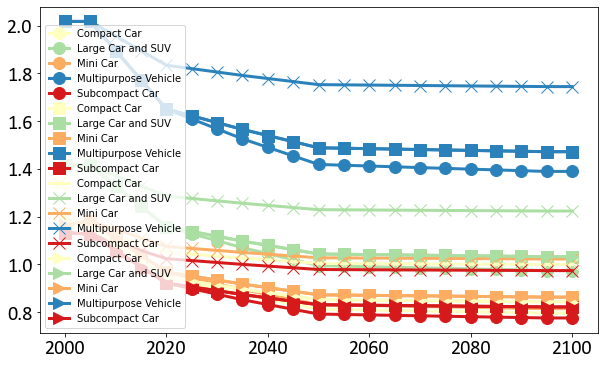

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xticks(fontname="Calibri", fontsize=20)
plt.yticks(fontname="Calibri", fontsize=20)
for key in trn_xml_path.keys():
    df = (
        pd.DataFrame(
            ene_intensity(trn_xml_path[key]),
            columns=columns,
            index=tranSubsector_name_ls,
        )
        / 1000000
    )
    df.T.plot(
        linewidth=3,
        ax=ax,
        color=carType_cmap,
        marker=mar_dict[key],
        markersize=12,
        legend=False,
    )
plt.legend()
plt.savefig(
    r"D:\tencent_files\chrome_Download\Research\Equilibium_modelling\H2MetalDemand\Figures\ene_inten_FCEV.png",
    transparent=True,
    dpi=600,
)

In [22]:
ann_travel_distance = np.array(
    [
        19486,
        19650,
        21932,
        9466,
        21632,
    ]
)  # km/year, data from article: Vehicle-use intensity in China: Current status and future trend
# 18886   km/year, data from https://acp.copernicus.org/articles/17/12709/2017/acp-17-12709-2017.html
# ann_travel_distance = 8000 km/year, data for less developed EU countries from https://www.odyssee-mure.eu/publications/efficiency-by-sector/transport/distance-travelled-by-car.html

In [23]:
def trn_stock(
    excel_name,
    ene_intensity_ls,
    sheet_name=sheet_name[3],
):
    Stock = open_sheet(excel_name, sheet_name)
    Stock_H2_con = Stock.groupby(level=3).sum()
    factor = (np.array(ene_intensity_ls).T * ann_travel_distance).T
    FCEV_trn_distance = Stock_H2_con * EJ_to_J / factor
    FCEV_trn_distance["unit"] = "vehicle"
    FCEV_trn_distance.set_index("unit", append=True, inplace=True)
    return FCEV_trn_distance

In [24]:
trn_stock(
    scenario_name_list[0], ene_intensity(trn_xml_path["ssp2"]), sheet_name=sheet_name[3]
)

,,1990,2005,2010,2015,2020,2025,2030,2035,2040,2045,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
,unit,,,,,,,,,,,,,,,,,,,,,
Compact Car,vehicle,0.0,0.0,0.0,0.0,9906.403734,29649.228225,53233.291120,78375.676998,98539.294770,116819.672817,...,143659.877561,162445.246730,187938.621779,219373.305814,257893.774266,304379.692493,361809.765991,435742.393217,523109.783853,591675.596485
Large Car and SUV,vehicle,0.0,0.0,0.0,0.0,16364.196786,52124.766663,100832.304536,159347.134044,213948.218031,269580.287068,...,369819.533833,420286.682538,473771.529279,531020.048110,592007.850826,658674.711496,731693.377401,816622.497034,908856.838201,972617.410765
Mini Car,vehicle,0.0,0.0,0.0,0.0,256.687996,760.329534,1394.199018,2116.971889,2839.060557,3737.278395,...,5730.406970,7222.273537,9739.517765,13473.156937,19172.013026,28600.903701,44894.138511,75532.711569,126348.368734,169838.358874
Multipurpose Vehicle,vehicle,0.0,0.0,0.0,0.0,62.453966,212.021944,437.290208,739.746396,1088.952342,1531.898057,...,2593.617337,3184.456076,3833.017028,4551.585014,5338.337889,6222.707519,7194.484546,8300.127856,9468.913172,10181.488494
Subcompact Car,vehicle,0.0,0.0,0.0,0.0,1454.819600,4529.338169,8510.368393,13255.010165,17984.711686,23661.546228,...,36091.986826,44769.473590,57498.768317,74969.041091,99363.858687,133728.205203,185154.462341,265008.943516,377318.155519,479417.404805


In [25]:
def excel_output(excel_name, func):
    with ExcelWriter(os.path.join(path, excel_name)) as Writer:
        for scenario in scenario_name_list:
            sheet_name = scenario[:-5]
            try:
                if func != trn_stock:
                    func(scenario).to_excel(Writer, sheet_name=sheet_name)
                else:
                    func(scenario, ene_intensity(trn_xml_path[scenario[:4]])).to_excel(
                        Writer, sheet_name=sheet_name
                    )
            except:
                print(scenario + " data not available")

In [26]:
excel_output("stock_prod.xlsx", prod_stock)

In [27]:
excel_output("stock_ind.xlsx", ind_stock)

In [28]:
excel_output("stock_trn.xlsx", trn_stock)